# Data Preprocessing

The data is formatted as JSON separated by newline. Using pandas to read dataset

In [1]:
import matplotlib.pyplot as plt
import findspark
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
findspark.init()

sc = SparkContext

spark = SparkSession \
    .builder \
    .appName("Amazon Sentiment Analysis") \
    .getOrCreate()

dataframe = spark.read.json("./assets/Software_5.json")

print(dataframe.printSchema())
print("Data read", dataframe.count())
print(dataframe.describe())


root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Package Type:: string (nullable = true)
 |    |-- Platform:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-- Style Name:: string (nullable = true)
 |    |-- Style:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: string (nullable = true)

None
Data read 12805
DataFrame[summary: string, asin: string, overall: string, reviewText: string, reviewTime: string, reviewerID: string, reviewerName:

The feature `vote` tells us if the review is helpful or not. To better classifying our data, we want to remove all reviews that have no vote.

Also, note that the data type of `vote` is `object`. But since vote can only be a number, we want to convert vote to `int64` data type

Now after preprocessing the vote, we can see that the data type of vote is `int64`

In [2]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, IntegerType

df = dataframe.dropna(how="any", subset=["vote", "overall", "reviewText"])
# Some vote has , in number, we just need to remove it

def convert_to_int(text: str) -> int:
    return int(text.replace(",", ""))


process_vote = udf(lambda q: convert_to_int(q), IntegerType())

df = df.withColumn("vote", process_vote(col("vote")))
print(df.printSchema())


root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Package Type:: string (nullable = true)
 |    |-- Platform:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-- Style Name:: string (nullable = true)
 |    |-- Style:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: integer (nullable = true)

None


For feature `reviewText`, we want to do some pre processing steps on the text. Notably:

- Lemmetization  
- Expand contraction   
- Lower all words

In [3]:
import nltk
import string
import contractions
nltk.download('stopwords')


def remove_special_symbol(text: str) -> str:
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def lower_text(text: str) -> str:
    return text.lower()


def remove_stop_words(text: str) -> str:
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    return ' '.join(
        [word for word in text.split() if word not in (stop_words)])


def expand_contraction(text: str) -> str:
    return contractions.fix(text)


def stemming(text: str) -> str:
    stemmer = nltk.stem.SnowballStemmer("english")
    return stemmer.stem(text)


process_review = udf(lambda q: stemming(remove_special_symbol(
    remove_stop_words(expand_contraction(lower_text(q))))), StringType())

df = df.withColumn("processed_review", process_review(col("reviewText")))

df.show()


[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+----------+--------------------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------------+--------------+--------+----+--------------------+
|      asin|               image|overall|          reviewText| reviewTime|    reviewerID|       reviewerName|               style|             summary|unixReviewTime|verified|vote|    processed_review|
+----------+--------------------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------------+--------------+--------+----+--------------------+
|0321719816|                null|    5.0|If you've been wa...|10 16, 2010| ACJT8MUC0LRF0|          D. Fowler|{null,  DVD-ROM, ...|This is excellent...|    1287187200|   false|   3|wanting learn cre...|
|0321719816|                null|    5.0|I have also taken...|10 28, 2010|A2WCFDOCS73PNB|          Gadgetman|{null,  DVD-ROM, ...|Excellent value f...|    1288224000|   false|   4|also taken l

Each review is assigned an overall score from 1.0 to 5.0. Convert those scores to labels where -1 is negative, 0 is neutral and 1 is positive. We also remove neutral sentiment

In [4]:
# PySpark only allows classification label to be 0 and 1 only
# We don't need neutral review so I set it to -1
def sentiment_from_overall(number):
    if number < 3.0:
        return 0
    if number == 3.0:
        return -1
    return 1


add_sentiment = udf(lambda q: sentiment_from_overall(q), IntegerType())
df = df.withColumn("label", add_sentiment(col("overall")))

# Drop column with -1 (neutral) sentiment
df = df.filter(df["label"] != -1)
df.show()


+----------+--------------------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------------+--------------+--------+----+--------------------+-----+
|      asin|               image|overall|          reviewText| reviewTime|    reviewerID|       reviewerName|               style|             summary|unixReviewTime|verified|vote|    processed_review|label|
+----------+--------------------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------------+--------------+--------+----+--------------------+-----+
|0321719816|                null|    5.0|If you've been wa...|10 16, 2010| ACJT8MUC0LRF0|          D. Fowler|{null,  DVD-ROM, ...|This is excellent...|    1287187200|   false|   3|wanting learn cre...|    1|
|0321719816|                null|    5.0|I have also taken...|10 28, 2010|A2WCFDOCS73PNB|          Gadgetman|{null,  DVD-ROM, ...|Excellent value f...|    1288224000|  

# Visualization

We first need to convert Spark SQL DataFrame to Panda Dataframe

In [5]:
panda_df = df.toPandas()

Exploratory data analysis on overall rating column

In [6]:
panda_df.describe()

,overall,unixReviewTime,vote,label
count,3383.000000,3.383000e+03,3383.000000,3383.000000
mean,3.424180,1.298942e+09,18.106414,0.644694
std,1.665412,1.119760e+08,107.271995,0.478677
min,1.000000,9.619776e+08,2.000000,0.000000
25%,1.000000,1.220573e+09,2.000000,0.000000
50%,4.000000,1.294099e+09,4.000000,1.000000
75%,5.000000,1.395533e+09,11.000000,1.000000
max,5.000000,1.526515e+09,5365.000000,1.000000


Plotting pie chart and bar chart for overall score distribution. The 'overall' column has 5 labels: 1.0, 2.0, 3.0, 4.0, 5.0 where 1.0 is very bad, 3.0 is neutral and 5.0 is very good.

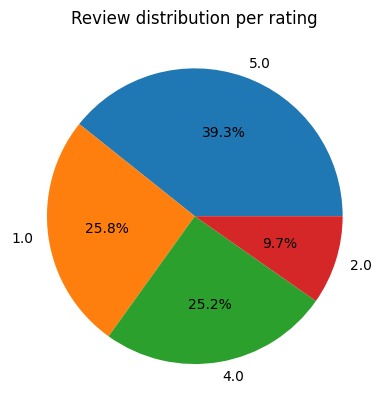

<AxesSubplot: title={'center': 'Review count per rating'}>

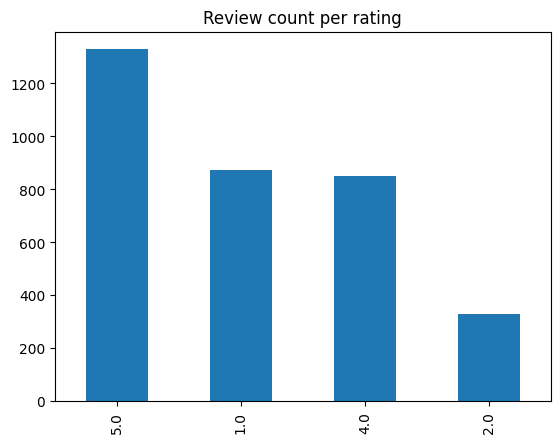

In [7]:
scores = panda_df["overall"].value_counts()
index = scores.index.to_numpy()
scores = scores.to_numpy()
plt.pie(scores, labels=index, autopct='%1.1f%%')
plt.title("Review distribution per rating")
plt.show()
panda_df['overall'].value_counts().plot(kind='bar',title="Review count per rating")


We get the same statistic, but this time with sentiment

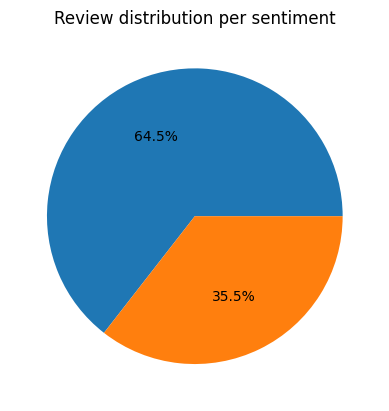

<AxesSubplot: title={'center': 'Review count per sentiment'}>

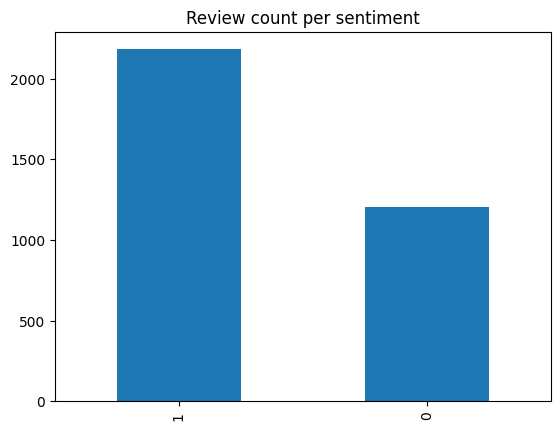

In [8]:
def sentiment_to_word(number):
    if number == 1:
        return "Positive"
    return "Negative"

scores = panda_df["label"].value_counts()
index = [sentiment_to_word(x) for x in scores]
scores = scores.to_numpy()
plt.pie(scores, autopct='%1.1f%%')
plt.title("Review distribution per sentiment")
plt.show()
panda_df['label'].value_counts().plot(kind='bar',title="Review count per sentiment")


Now, we get statistics on reivewText length. To visualize this, we use a boxplot

Statistic of text length
 count     3383.000000
mean      1110.303872
std       1411.979972
min          3.000000
25%        346.500000
50%        714.000000
75%       1393.500000
max      23075.000000
Name: processed_review, dtype: float64


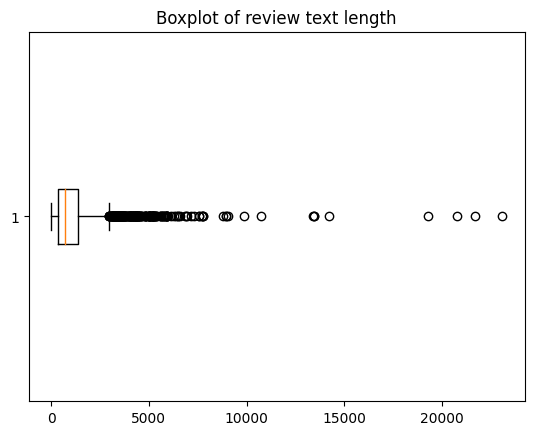

In [9]:
text_length = panda_df["processed_review"].apply(len)
print("Statistic of text length\n", text_length.describe())
# To visualize this, we use boxplot
plt.title("Boxplot of review text length")
plt.boxplot(text_length, vert=False)
plt.show()


Wordcloud to visualize top words in our `processed_review` column

Text(0.5, 1.0, 'Most popular words in dataset')

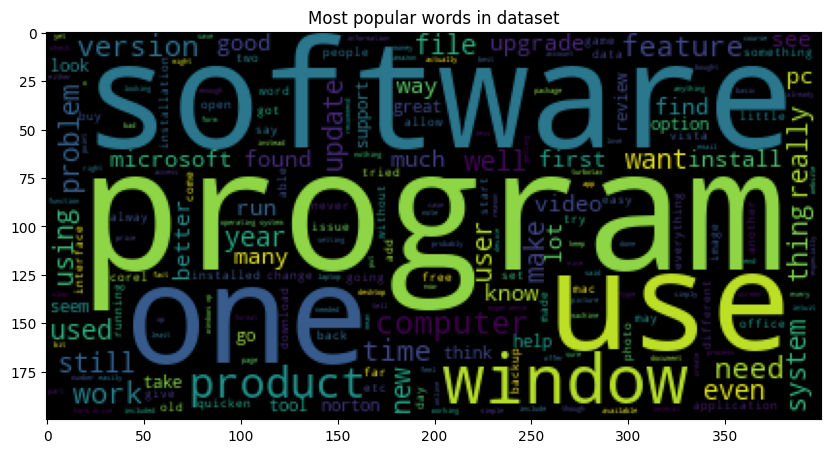

In [10]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(panda_df['processed_review']))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(wordcloud)
ax.set_title("Most popular words in dataset")


Next up, we want to visualize the correlation between `vote` and `rating` in our dataframe. There is no correlation between `vote` and `rating`. Therefore,
we conclude that by removing samples that have no `vote`, it creates no bias for our dataset

<AxesSubplot: title={'center': 'Correlation between features'}>

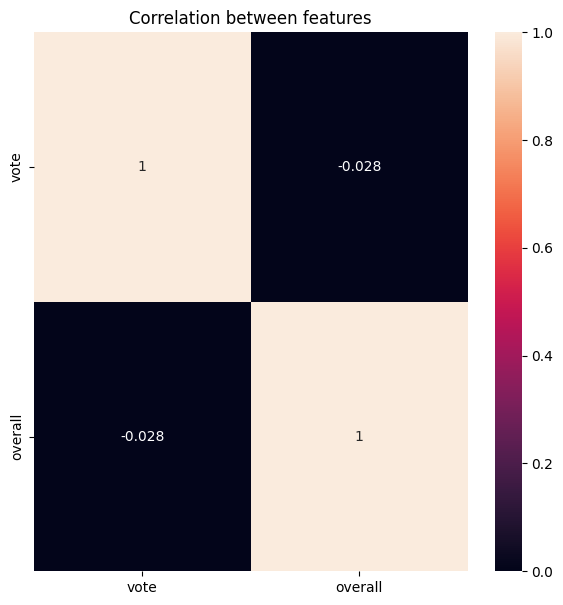

In [11]:
from seaborn import heatmap

correlation = panda_df[["vote", "overall"]].corr()
plt.figure(figsize=(7, 7))
plt.title("Correlation between features")
heatmap(correlation, vmin=0, vmax=1, annot=True)


# Algorithms

In [12]:
# We only care about sentiment and processed review column
df = df.select(["label", "processed_review"])
df.show()


+-----+--------------------+
|label|    processed_review|
+-----+--------------------+
|    1|wanting learn cre...|
|    1|also taken local ...|
|    1|even though use d...|
|    1|adobe approved ad...|
|    0|using office twen...|
|    1|using ms office p...|
|    1|really great buy ...|
|    1|bottom line like ...|
|    0|complete rubbish ...|
|    1|real question  ca...|
|    0|try install recei...|
|    1|us microsoft offi...|
|    1|note mac users on...|
|    1|even though glo w...|
|    1|bible software li...|
|    1|glo visually stun...|
|    1|nearly enough loo...|
|    1|took little hour ...|
|    1|got installed com...|
|    1|me willmaker serv...|
+-----+--------------------+
only showing top 20 rows



We will separate our data into 3 sets which are `trainning`, `validation` and `testing`.

The trainning step will be used to create our model, we want to config parameters that will generalize well in this step

Validation step will be used for hyperparameter tuning, to maximize our model's accuracy.

Finally, we measure and compare our results using the test set.

We will split the dataset in the following ration: 80, 10 and 10.

In [13]:
train, test = df.randomSplit([0.8, 0.2], seed=22)
train.cache()
print("Train samples:", train.count())
print("Test samples:", test.count())


Train samples: 2689
Test samples: 694


Next up, we need to extract features from our text data. This will act as an input to our ML model. There are many options that we can choose from, notably:

1, **TF-IDF**: Stands for Term Frequency – Inverse Document Frequency

2, **Count Vectorizer**

We will use TF-IDF for feature extraction. The reason is that Count Vectorizer only focuses on the frequency of the word, which results in biasing in favour of popular words. For example, the word `the` will be counted a lot but does not hold any significant meaning. Meanwhile, using TF-IDF, we can avoid common words that does not carry any sentiment

In [14]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, NGram
from pyspark.ml import Pipeline
# Train model with Logistic Regression
from pyspark.ml.classification import LogisticRegression

# Split word by space
tokenizer = Tokenizer(inputCol="processed_review",
                      outputCol="words")

# In the future, we also train on bigram... For now just unigram
# ngram = NGram(n=1, inputCol="tokenized_review", outputCol="unigram")
# unigram_word = ngram.transform(word_data)

# Use TF IDF
hashingTF = HashingTF(inputCol="words",
                      outputCol="rawFeatures", numFeatures=5)

# Scaling
idf = IDF(inputCol="rawFeatures", outputCol="features")
# Use Logistic Regression
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])


The `evaluate_model` is our metrics to determine if our model is good or not in this project

In [15]:
# Show accuracy score, f1 score, recall score and confusion matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.sql.dataframe import DataFrame


def evaluate_model(dataframe: DataFrame):
    # Need to convert to double to feed into BinaryClassificationMetrics
    # Instantiate metrics object
    scoreAndLabels = dataframe.select(["prediction", "label"]).rdd.map(
        lambda xs: [float(x) for x in xs])
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    print("Area under PR:", metrics.areaUnderPR)
    print("Area under ROC:", metrics.areaUnderROC)

    multi_metrics = MulticlassMetrics(scoreAndLabels.map(tuple))
    ax = plt.subplot()
    heatmap(multi_metrics.confusionMatrix().toArray(),
            annot=True, fmt='g', ax=ax, cmap="crest", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    print("Accuracy:", multi_metrics.accuracy)
    print("Weighted Precision:", multi_metrics.weightedPrecision)
    print("Weighted Recall", multi_metrics.weightedRecall)
    print("Weighted F Score", multi_metrics.weightedFMeasure())
    print("Weighted False Positive Rate",
          multi_metrics.weightedFalsePositiveRate)
    print("Weighted True Positive Rate",
          multi_metrics.weightedTruePositiveRate)


Hyperparameter turning to choose optimal variable for our model. Here we use `K Fold Cross Validation` to tune the parameter

In [16]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
param_grid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [5, 100, 1000]) \
    .addGrid(lr.threshold, [0.62, 0.65]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

cross_validator = crossval.fit(train)

The best params used are...

In [17]:
import numpy as np

print(cross_validator.getEstimatorParamMaps()[np.argmax(cross_validator.avgMetrics)])

{Param(parent='HashingTF_5e7b5bb51ad2', name='numFeatures', doc='Number of features. Should be greater than 0.'): 1000, Param(parent='LogisticRegression_60d1277387d0', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.62}


Evaluate results after hyper parameter tuning. We achieved near 100% accuracy after tuning the parameters!!!

c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area under PR: 0.9998962555917482
Area under ROC: 0.999710312862109
Accuracy: 0.9996281145407214
Weighted Precision: 0.9996285003140195
Weighted Recall 0.9996281145407214
Weighted F Score 0.9996281571532686
Weighted False Positive Rate 0.00020748881650361307
Weighted True Positive Rate 0.9996281145407214


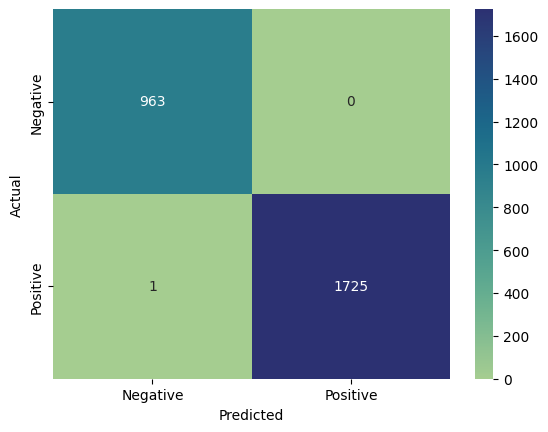

In [18]:
evaluate_model(cross_validator.transform(train))

Now we use our optimized logistic regression with our test data

Area under PR: 0.8379368408307215
Area under ROC: 0.7721734332612993
Accuracy: 0.7780979827089337
Weighted Precision: 0.7887134743888508
Weighted Recall 0.7780979827089337
Weighted F Score 0.7812988060446551
Weighted False Positive Rate 0.23375111618633498
Weighted True Positive Rate 0.7780979827089337


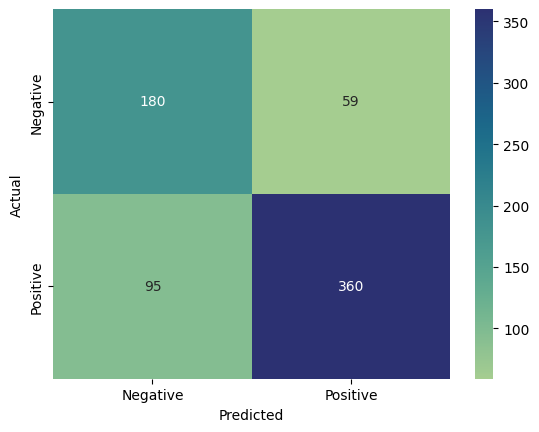

In [19]:
evaluate_model(cross_validator.transform(test))